Dataset

In [1]:
import pandas as pd

df = pd.read_csv('TUANDROMD.csv', skip_blank_lines=True).dropna()
# Вывод распределения по классам
class_distribution = df['Label'].value_counts()
print(class_distribution)
df


malware     3565
goodware     899
Name: Label, dtype: int64


,ACCESS_ALL_DOWNLOADS,ACCESS_CACHE_FILESYSTEM,ACCESS_CHECKIN_PROPERTIES,ACCESS_COARSE_LOCATION,ACCESS_COARSE_UPDATES,ACCESS_FINE_LOCATION,ACCESS_LOCATION_EXTRA_COMMANDS,ACCESS_MOCK_LOCATION,ACCESS_MTK_MMHW,ACCESS_NETWORK_STATE,...,Landroid/telephony/TelephonyManager;->getLine1Number,Landroid/telephony/TelephonyManager;->getNetworkOperator,Landroid/telephony/TelephonyManager;->getNetworkOperatorName,Landroid/telephony/TelephonyManager;->getNetworkCountryIso,Landroid/telephony/TelephonyManager;->getSimOperator,Landroid/telephony/TelephonyManager;->getSimOperatorName,Landroid/telephony/TelephonyManager;->getSimCountryIso,Landroid/telephony/TelephonyManager;->getSimSerialNumber,Lorg/apache/http/impl/client/DefaultHttpClient;->execute,Label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,malware
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,malware
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,malware
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,malware
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,malware
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4460,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,goodware
4461,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,goodware
4462,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,goodware
4463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,goodware


Encoding

In [2]:
df_enc = df.copy()
df_enc['Label'] = df_enc['Label'].apply(lambda x: 1 if x == 'malware' else 0)

In [3]:
# Data Split
from sklearn.model_selection import train_test_split
X = df_enc.drop('Label', axis=1).to_numpy()
y = df_enc['Label'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Logistic Regression

In [4]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

Metrics

In [5]:
from sklearn.metrics import accuracy_score, recall_score, precision_score

acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
print(f"Accuracy\t{acc * 100:.2f}%")
print(f"Recall\t\t{recall * 100:.2f}%")
print(f"Precision\t{precision * 100:.2f}%")


Accuracy	98.43%
Recall		98.61%
Precision	99.44%


Curves

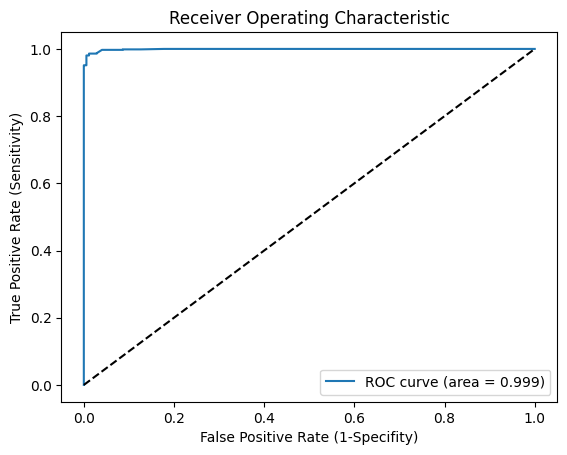

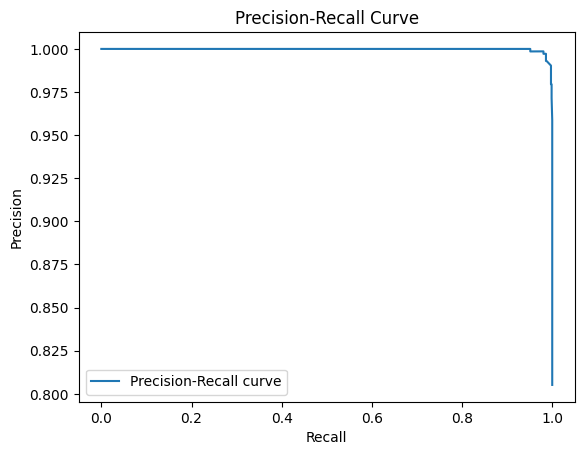

In [6]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

# Вычисление вероятностей классов
y_scores = logreg.predict_proba(X_test)

# Вычисление ROC AUC
fpr, tpr, _ = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)

# Построение ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate (1-Specifity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Вычисление Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_scores[:, 1])

# Построение Precision-Recall curve
plt.figure()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


Cross Validation

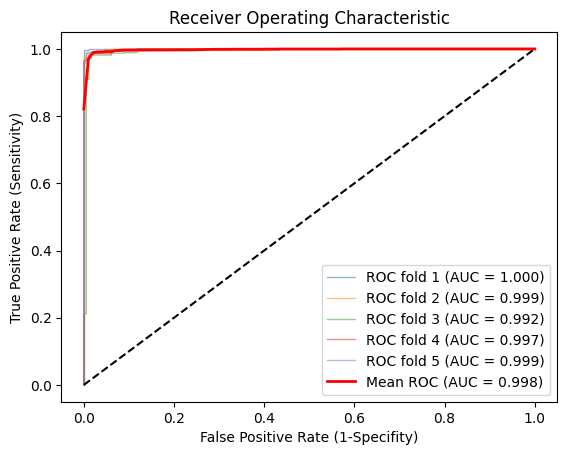

In [16]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

cv = StratifiedKFold(n_splits=5)

tprs = []
mean_fpr = np.linspace(0, 1, 100)

for i, (train, test) in enumerate(cv.split(X, y)):
    logreg.fit(X[train], y[train])
    y_scores = logreg.predict_proba(X[test])

    fpr, tpr, thresholds = roc_curve(y[test], y_scores[:, 1])
    roc_auc = auc(fpr, tpr)
    # Интерполяция TPR для текущего фолда
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    plt.plot(fpr, tpr, lw=1, alpha=0.5, label=f'ROC fold {i+1} (AUC = {roc_auc:.3f})')

mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='red', label=f'Mean ROC (AUC = {mean_auc:.3f})', lw=2)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate (1-Specifity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
